In [78]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as ppt
from sklearn import linear_model
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from linearmodels import OLS
from linearmodels import PanelOLS
from linearmodels import PooledOLS
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Functions

In [79]:
def plot_residuals_for_variance(exog,endog):
    # Perform PooledOLS
    mod = PooledOLS(endog, exog)
    pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
    # Store values for checking homoskedasticity graphically
    fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
    residuals_pooled_OLS = pooledOLS_res.resids
    # 3A. Homoskedasticity
    #import matplotlib.pyplot as plt
     # 3A.1 Residuals-Plot for growing Variance Detection
    fig, ax = ppt.subplots()
    ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
    ax.axhline(0, color = 'r', ls = '--')
    ax.set_xlabel('Predicted Values', fontsize = 15)
    ax.set_ylabel('Residuals', fontsize = 15)
    ax.set_title('Homoskedasticity Test', fontsize = 30)
    ppt.show()
    return residuals_pooled_OLS

def do_WhiteTest(df_panel,residuals_pooled_OLS,exog,endog):
    # --> heteroskedasticity if growing variance
    # 3A.2 White-Test
    pooled_OLS_dataset = pd.concat([df_panel, residuals_pooled_OLS], axis=1)
    #pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
    #pooled_OLS_dataset.head()
    exog = sm.tools.tools.add_constant(exog).fillna(0)
    white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
    print('White test: Heteroscedasticity cannot be refused if p-Value close to zero')
    labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
    print(dict(zip(labels, white_test_results)))
    # 3A.3 Breusch-Pagan-Test
    breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
    print('Breusch-Pagan test: Heteroscedasticity cannot be refused if p-Value close to zero')
    labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
    print(dict(zip(labels, breusch_pagan_test_results)))
    return pooled_OLS_dataset

def do_DurbinWatsonTest(pooled_OLS_dataset):
    # 3.B Non-Autocorrelation
    # Durbin-Watson-Test
    durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
    print('Durbin-Watson test: [0,2) - pos autocorrelation; 2 - no autocorr; (2,4] - neg autocorrelation')
    print(durbin_watson_test_results)
    # --> [0,2) - pos autocorrelation; 2 - no autocorr; (2,4] - neg autocorrelation

# Test models

In [80]:
# Create panel
first_year = 2014
last_year = 2020
N = 600
entity_list = [str(i).zfill(3) for t in range(first_year,last_year+1) for i in range(N)]
df_panel = pd.DataFrame(index=range(len(entity_list)),columns=['year','RS'])
df_panel['year'] = list(range(first_year,last_year+1))*N
df_panel['RS'] = entity_list
df_panel.set_index(['RS','year'],inplace=True)
df_panel['const'] = 1.

# Linear model without time dependencies

In [81]:
# Create data
a = 10.
b = 2.
sigma = 1.
df_panel['x'] = np.random.randint(0, 10, df_panel.shape[0])
df_panel['eps'] = np.random.normal(0, sigma, df_panel.shape[0])
df_panel['y'] = a + b*df_panel['x'] + df_panel['eps']
df_panel.head()

,,const,x,eps,y
RS,year,,,,
000,2014,1.0,0,0.363302,10.363302
001,2015,1.0,3,1.228159,17.228159
002,2016,1.0,5,-1.178146,18.821854
003,2017,1.0,5,0.606930,20.606930
004,2018,1.0,3,-1.326205,14.673795


In [82]:
exog = df_panel[['const','x']]
endog = df_panel['y']
mod = OLS(endog, exog) #, entity_effects=True,time_effects=True)
res = mod.fit() #cov_type='clustered', cluster_entity=True)
print(res)

                            OLS Estimation Summary                            
Dep. Variable:                      y   R-squared:                      0.9726
Estimator:                        OLS   Adj. R-squared:                 0.9726
No. Observations:                4200   F-statistic:                 1.501e+05
Date:                Fri, Jul 02 2021   P-value (F-stat)                0.0000
Time:                        11:02:52   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          10.008     0.0277     361.16     0.0000      9.9533      10.062
x              2.0001     0.0052     387.48     0.00

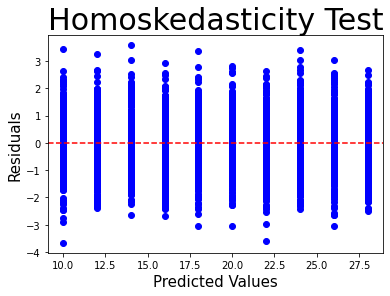

White test: Heteroscedasticity cannot be refused if p-Value close to zero
{'LM-Stat': 0.35795510066356506, 'LM p-val': 0.8361246699077667, 'F-Stat': 0.17886495342019512, 'F p-val': 0.8362251942109009}
Breusch-Pagan test: Heteroscedasticity cannot be refused if p-Value close to zero
{'LM-Stat': 0.20187335672858797, 'LM p-val': 0.6532129567541054, 'F-Stat': 0.20178692546441512, 'F p-val': 0.6533055298603516}
Durbin-Watson test: [0,2) - pos autocorrelation; 2 - no autocorr; (2,4] - neg autocorrelation
2.01301656403157


In [83]:
# Test for endogeneity
exog = df_panel[['const','x']]
endog = df_panel['y']
residuals_pooled_OLS = plot_residuals_for_variance(exog,endog)
pooled_OLS_dataset = do_WhiteTest(df_panel,residuals_pooled_OLS,exog,endog)
do_DurbinWatsonTest(pooled_OLS_dataset)

In [84]:
# With fixed-effects
mod = PanelOLS(endog, exog, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.9725
Estimator:                   PanelOLS   R-squared (Between):              0.9716
No. Observations:                4200   R-squared (Within):               0.9727
Date:                Fri, Jul 02 2021   R-squared (Overall):              0.9726
Time:                        11:03:00   Log-likelihood                   -5837.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.484e+05
Entities:                         600   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                  F(1,4192)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):          1.569e+05
                            

"I can pool" cannot be rejected --> pooling is ok.

# Linear model with random time effects

In [87]:
# Create data
a = 10.
b = 2.
sigma = 1.
df_panel['x'] = np.random.randint(0, 10, df_panel.shape[0])
df_panel['time_FE'] = 0
for year in range(first_year,last_year+1):
    df_panel['time_FE'].loc[df_panel.index.get_level_values(1) == year] = np.random.randint(0, 5)
df_panel['eps'] = np.random.normal(0, sigma, df_panel.shape[0])
df_panel['y'] = a + b*df_panel['x'] + df_panel['time_FE'] + df_panel['eps']
df_panel.iloc[:10]

,,const,x,eps,y,time_FE
RS,year,,,,,
000,2014,1.0,7,0.545235,28.545235,4
001,2015,1.0,2,-0.637742,13.362258,0
002,2016,1.0,8,0.727018,28.727018,2
003,2017,1.0,4,0.952010,19.952010,1
004,2018,1.0,1,1.565227,15.565227,2
005,2019,1.0,9,-1.474712,28.525288,2
006,2020,1.0,8,-0.398030,26.601970,1
007,2014,1.0,6,0.042953,26.042953,4
008,2015,1.0,9,1.345194,29.345194,0


In [88]:
exog = df_panel[['const','x']]
endog = df_panel['y']
mod = OLS(endog, exog) #, entity_effects=True,time_effects=True)
res = mod.fit() #cov_type='clustered', cluster_entity=True)
print(res)

                            OLS Estimation Summary                            
Dep. Variable:                      y   R-squared:                      0.9323
Estimator:                        OLS   Adj. R-squared:                 0.9323
No. Observations:                4200   F-statistic:                 5.795e+04
Date:                Fri, Jul 02 2021   P-value (F-stat)                0.0000
Time:                        11:06:20   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          11.776     0.0442     266.47     0.0000      11.690      11.863
x              1.9893     0.0083     240.73     0.00

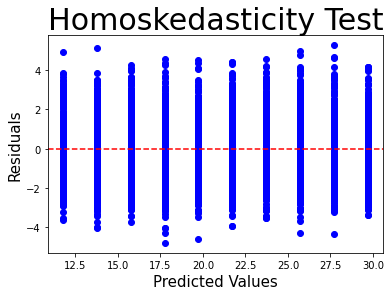

White test: Heteroscedasticity cannot be refused if p-Value close to zero
{'LM-Stat': 0.08839220089107425, 'LM p-val': 0.9567663167744413, 'F-Stat': 0.04416546129813341, 'F p-val': 0.9567960763996786}
Breusch-Pagan test: Heteroscedasticity cannot be refused if p-Value close to zero
{'LM-Stat': 0.08294669168598112, 'LM p-val': 0.7733431615999536, 'F-Stat': 0.08290883064565056, 'F p-val': 0.773407696001005}
Durbin-Watson test: [0,2) - pos autocorrelation; 2 - no autocorr; (2,4] - neg autocorrelation
2.7876091834183416


In [89]:
# Test for endogeneity
exog = df_panel[['const','x']]
endog = df_panel['y']
residuals_pooled_OLS = plot_residuals_for_variance(exog,endog)
pooled_OLS_dataset = do_WhiteTest(df_panel,residuals_pooled_OLS,exog,endog)
do_DurbinWatsonTest(pooled_OLS_dataset)

In [93]:
# With fixed-effects
mod = PanelOLS(endog, exog, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.9710
Estimator:                   PanelOLS   R-squared (Between):              0.9697
No. Observations:                4200   R-squared (Within):               0.9266
Date:                Fri, Jul 02 2021   R-squared (Overall):              0.9323
Time:                        11:07:02   Log-likelihood                   -5910.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.405e+05
Entities:                         600   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                  F(1,4192)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):          1.348e+05
                            

"I can pool" is rejected - I need to pool.